## Student Information
Gideon Shahar
204713689

Noy Rahmani  
311124416

## **Problem Definition**

Task: Multi-class image classification on the CIFAR-10 dataset

**CLASSES**  
The CIFAR-10 dataset contains 60,000 32x32 color images across 10 classes:

1. Airplane    - Commercial and military aircraft
2. Automobile  - Cars, sedans, and similar vehicles  
3. Bird        - Various bird species
4. Cat         - Domestic cats in different poses
5. Deer        - Wild deer
6. Dog         - Domestic dogs of various breeds
7. Frog        - Amphibians
8. Horse       - Horses in various settings
9. Ship        - Maritime vessels
10. Truck      - Larger vehicles, delivery trucks

**Dataset Split:**
- Training: 50,000 images (5,000 per class)
- Validation: 10,000 images (1,000 per class)

#### USE CASE & MOTIVATION

**Real-World Applications:**  
1. Automated Content Moderation
   - Filter and categorize user-uploaded images
   - Detect inappropriate content in social media

2. Educational Tools
   - Automatic labeling for children's learning apps
   - Interactive classification games

3. Research Baseline
   - CIFAR-10 is a standard benchmark for computer vision research
   - Allows comparison with state-of-the-art methods

4. Prototype for Complex Systems
   - Foundation for more specialized classifiers
   - Transfer learning base for domain-specific tasks

#### EXPECTED CHALLENGES

1. Low Resolution (32x32 pixels)
   - Limited fine-grained detail
   - Difficult to distinguish similar objects
   - Challenge: Extract meaningful features from small images

2. Intra-Class Variation
   - High variability within same class (e.g., different dog breeds)
   - Various poses, angles, and lighting conditions
   - Challenge: Generalize across diverse examples

3. Inter-Class Similarity
   - Cat vs Dog: Both are furry four-legged animals
   - Automobile vs Truck: Similar vehicle structures
   - Challenge: Learn discriminative features

4. Background Complexity
   - Cluttered backgrounds in some images
   - Occlusions and partial visibility
   - Challenge: Focus on relevant features

5. Class Balance
   - Equal distribution might not reflect real-world scenarios
   - Challenge: Ensure model doesn't overfit to artifacts

#### APPROACH

Training Strategy:
- Train (from scratch) ResNet18 / ResNet34 using fastai framework

Data Augmentation:
- Random flips, rotations, zoom
- Lighting adjustments
- Improves generalization

Evaluation Metrics:
- Overall accuracy
- Per-class accuracy
- Confusion matrix analysis
- Top loss visualization

#### SUCCESS CRITERIA

Target Performance:
- Overall accuracy: > 85%
- Balanced performance across classes
- Minimal confusion between dissimilar classes
- Identification of clear failure patterns

Expected Model Weaknesses:
1. Cat/Dog confusion due to visual similarity
2. Automobile/Truck overlap in features
3. Lower performance on classes with high variance (e.g., Bird)
4. Potential issues with unusual poses or occlusions


In [1]:
import sys
import fastai
from pathlib import Path
from fastai.vision.all import *
import shutil
import tarfile
import urllib.request
import numpy as np
from PIL import Image

print(sys.executable)
print("fastai version:", fastai.__version__)

/usr/bin/python3
fastai version: 2.8.5


## **Dataset Creation and Preparation**

In [2]:
# CIFAR10 class names
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

data_path = Path('data/cifar10')
cifar_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'

if not data_path.exists():
    print("Downloading CIFAR-10 dataset...")
    data_path.mkdir(parents=True, exist_ok=True)

    tar_path = data_path / 'cifar-10-python.tar.gz'
    urllib.request.urlretrieve(cifar_url, tar_path)

    print("Extracting dataset...")
    with tarfile.open(tar_path, 'r:gz') as tar:
        tar.extractall(data_path)

    tar_path.unlink()

    print("Organizing into train/test folders by class...")
    import pickle

    cifar_dir = data_path / 'cifar-10-batches-py'

    def unpickle(file):
        with open(file, 'rb') as f:
            return pickle.load(f, encoding='bytes')

    meta = unpickle(cifar_dir/'batches.meta')
    label_names = [name.decode('utf-8') for name in meta[b'label_names']]

    for split in ['train', 'test']:
        split_path = data_path/split
        split_path.mkdir(exist_ok=True)

        for label in label_names:
            (split_path/label).mkdir(exist_ok=True)

    for batch_id in range(1, 6):
        batch = unpickle(cifar_dir / f'data_batch_{batch_id}')
        for i, (img_data, label) in enumerate(zip(batch[b'data'], batch[b'labels'])):
            img = img_data.reshape(3, 32, 32).transpose(1, 2, 0)
            label_name = label_names[label]
            img_path = data_path / 'train' / label_name / f'batch{batch_id}_img{i}.png'
            Image.fromarray(img).save(img_path)

    test_batch = unpickle(cifar_dir / 'test_batch')
    for i, (img_data, label) in enumerate(zip(test_batch[b'data'], test_batch[b'labels'])):
        img = img_data.reshape(3, 32, 32).transpose(1, 2, 0)
        label_name = label_names[label]
        img_path = data_path / 'test' / label_name / f'test_img{i}.png'
        Image.fromarray(img).save(img_path)

    shutil.rmtree(cifar_dir)

    print("Dataset organized successfully!")
else:
    print("CIFAR-10 dataset already exists.")


Extracting dataset...


/tmp/ipython-input-905906163.py:16: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tar.extractall(data_path)


Organizing into train/test folders by class...
Dataset organized successfully!


In [3]:

print("Dataset Statistics")

train_path = data_path / 'train'
test_path = data_path / 'test'

classes = sorted([d.name for d in train_path.iterdir() if d.is_dir()])
print(f"\nClasses ({len(classes)}): {', '.join(classes)}")

train_counts = {cls: len(list((train_path/cls).glob('*.png'))) for cls in classes}
test_counts = {cls: len(list((test_path/cls).glob('*.png'))) for cls in classes}

print(f"\nTrain images per class:")
for cls in classes:
    print(f"  {cls:12s}: {train_counts[cls]:4d}")
print(f"  {'Total':12s}: {sum(train_counts.values()):4d}")

print(f"\nTest images per class:")
for cls in classes:
    print(f"  {cls:12s}: {test_counts[cls]:4d}")
print(f"  {'Total':12s}: {sum(test_counts.values()):4d}")

Dataset Statistics

Classes (10): airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck

Train images per class:
  airplane    : 5000
  automobile  : 5000
  bird        : 5000
  cat         : 5000
  deer        : 5000
  dog         : 5000
  frog        : 5000
  horse       : 5000
  ship        : 5000
  truck       : 5000
  Total       : 50000

Test images per class:
  airplane    : 1000
  automobile  : 1000
  bird        : 1000
  cat         : 1000
  deer        : 1000
  dog         : 1000
  frog        : 1000
  horse       : 1000
  ship        : 1000
  truck       : 1000
  Total       : 10000


## **Dataset Loading**

In [4]:
print("Creating DataLoaders for CIFAR-10...")

cifar_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(224),
    batch_tfms=aug_transforms(mult=2.0, do_flip=True, flip_vert=False,
                              max_rotate=15.0, max_zoom=1.1,
                              max_lighting=0.2, max_warp=0.2)
)

dls = cifar_block.dataloaders(train_path, bs=64)

print(f"Train batches: {len(dls.train)}")
print(f"Valid batches: {len(dls.valid)}")
print(f"Batch size: {dls.bs}")
print(f"Classes: {dls.vocab}")
print(f"Number of classes: {len(dls.vocab)}")

test_files = get_image_files(test_path)
print(f"\nTest set images found: {len(test_files)}")

Creating DataLoaders for CIFAR-10...
Train batches: 625
Valid batches: 157
Batch size: 64
Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Number of classes: 10

Test set images found: 10000


Training Set - Sample Batch (with augmentations)


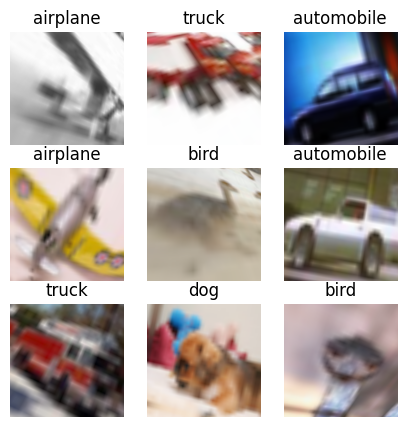

In [5]:
# training examples
print("Training Set - Sample Batch (with augmentations)")
dls.show_batch(max_n=9, figsize=(5, 5))

Validation Set - Sample Batch (no augmentations)


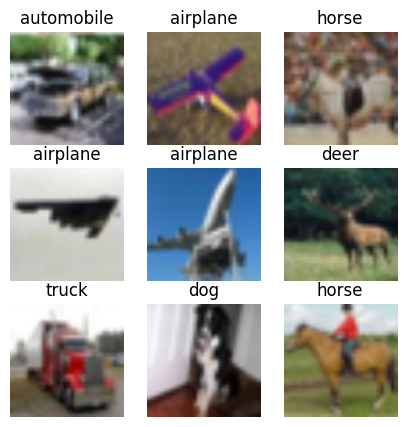

In [6]:
# validation examples
print("Validation Set - Sample Batch (no augmentations)")
dls.valid.show_batch(max_n=9, figsize=(5, 5))

## **Model Training**

In [7]:
print("Setting up training configuration...")

arch = resnet18
lr = 1e-3
epochs = 5
freeze_epochs = 3

print(f"Architecture: {arch.__name__}")
print(f"Learning rate: {lr}")
print(f"Freeze epochs: {freeze_epochs}")
print(f"Fine-tune epochs: {epochs}")

print("Creating learner with transfer learning...")
learn = vision_learner(dls, arch, metrics=[accuracy, error_rate])

print("\nPhase 1: Training with frozen layers")
learn.fine_tune(epochs, base_lr=lr, freeze_epochs=freeze_epochs)
print("Training complete!")

results = learn.validate()
print(f"\nFinal validation loss: {results[0]:.4f}")
print(f"Final validation accuracy: {results[1]:.4f}")
print(f"Final validation error rate: {results[2]:.4f}")

learn.save('cifar10_resnet18')
print("\nModel saved as 'cifar10_resnet18'")

Setting up training configuration...
Architecture: resnet18
Learning rate: 0.001
Freeze epochs: 3
Fine-tune epochs: 5
Creating learner with transfer learning...
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 211MB/s]



Phase 1: Training with frozen layers


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,1.433754,0.740447,0.751900,0.248100,02:06
1,1.012066,0.547422,0.809200,0.190800,02:02
2,0.782472,0.423470,0.852000,0.148000,02:04


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.498703,0.273519,0.909000,0.091000,02:34
1,0.396946,0.210699,0.926400,0.073600,02:33
2,0.323462,0.176587,0.940800,0.059200,02:32
3,0.247503,0.159730,0.947400,0.052600,02:34
4,0.226958,0.156022,0.948200,0.051800,02:34


Training complete!



Final validation loss: 0.1560
Final validation accuracy: 0.9482
Final validation error rate: 0.0518

Model saved as 'cifar10_resnet18'


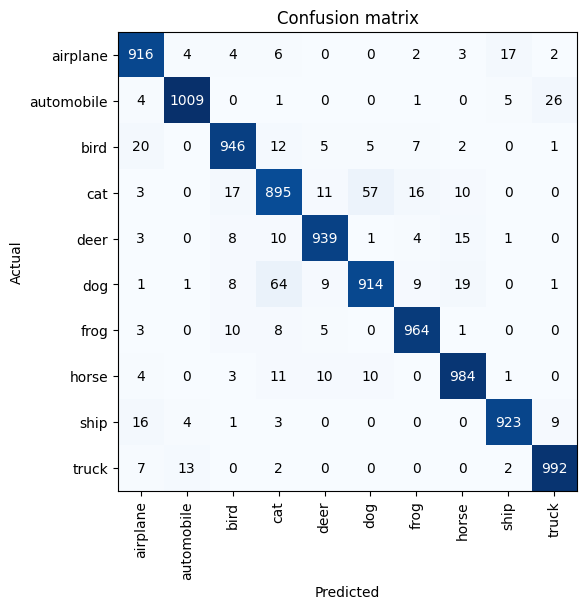

In [8]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(6,6))


In [9]:
interp.most_confused(min_val=15)


[('dog', 'cat', np.int64(64)),
 ('cat', 'dog', np.int64(57)),
 ('automobile', 'truck', np.int64(26)),
 ('bird', 'airplane', np.int64(20)),
 ('dog', 'horse', np.int64(19)),
 ('airplane', 'ship', np.int64(17)),
 ('cat', 'bird', np.int64(17)),
 ('cat', 'frog', np.int64(16)),
 ('ship', 'airplane', np.int64(16)),
 ('deer', 'horse', np.int64(15))]

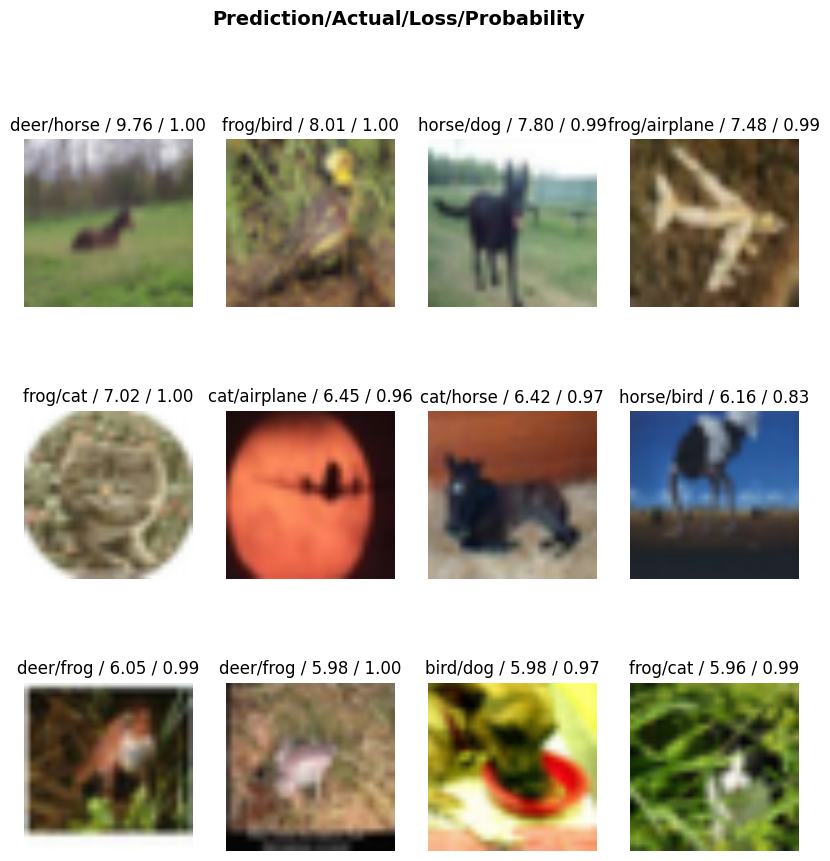

In [10]:
interp.plot_top_losses(12, figsize=(10,10))


In [13]:
# Build a test dataloader that also has labels
test_files = get_image_files(test_path)
test_dl = dls.test_dl(test_files, with_labels=True)

# Get predictions + targets and compute accuracy
test_preds, test_targets = learn.get_preds(dl=test_dl)
test_acc = accuracy(test_preds, test_targets)

# Option 1: pretty print with 4 decimal places
print(f"Test accuracy: {test_acc.item():.4f}")

# (or Option 2: no special formatting)
# print("Test accuracy:", test_acc)


Test accuracy: 0.9434
